In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from math import exp, floor, ceil, log, log2

import torchvision.datasets as datasets
import torchvision.transforms as transform
from torch.utils.data import Subset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

from sklearn.manifold import TSNE

In [ ]:
def togetNimagePerClass(mnist_data, PerClassNimage): 
    idxs = list()
    for i in range(10):
        ix = [k for k, n in enumerate(mnist_data.targets) if n == i]
        idxs.extend(ix[:PerClassNimage])
    DataTrain = Subset(mnist_data, idxs)            
    return DataTrain

In [ ]:
DatasetTrain = datasets.MNIST(
    root='./mnist-data/train', 
    train=True, 
    download=True, 
    transform=transform.ToTensor()
)

DataTestset = datasets.MNIST(
    root='./mnist-data/test', 
    train=False, 
    download=True, 
    transform=transform.ToTensor()
)

DataTrain = togetNimagePerClass(DatasetTrain, PerClassNimage=100)
Load_train = DataLoader(DataTrain, batch_size=40, shuffle=True)

DataTest = togetNimagePerClass(DataTestset, PerClassNimage=10)
Load_test = DataLoader(DataTest, batch_size=100, shuffle=True)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolutionOne = nn.Conv2d(1, 4, 5, padding=2, padding_mode='reflect')
        self.poolingOne = nn.MaxPool2d(2, 2)
        self.convolutiontwo = nn.Conv2d(4, 4, 5, padding=2, padding_mode='reflect')
        self.poolingtwo = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(7 * 7 * 4, 49)
        self.fc2 = nn.Linear(49, 10)

    def forward(self, x):
        ActivationMapOne = self.convolutionOne(x)                              # SizeOfTorch([40, 4, 28, 28])
        x = self.poolingOne(F.relu(ActivationMapOne))                      # SizeOfTorch([40, 4, 14, 14])
        ActivationMapTwo = self.convolutiontwo(x)                              # SizeOfTorch([40, 4, 14, 14])
        x = self.poolingtwo(F.relu(ActivationMapTwo))                      # SizeOfTorch([40, 4, 7, 7])
        BottleNeckFeatures = torch.flatten(x, 1)            # SizeOfTorch([40, 196])                   # leaving batch flatten all other dimensions
        x = F.relu(self.fc1(BottleNeckFeatures))            # SizeOfTorch([40, 49])
        x = F.softmax(self.fc2(x), dim=1)                    # SizeOfTorch([40, 10])
        return ActivationMapOne, ActivationMapTwo, BottleNeckFeatures, x

In [ ]:
def TrainTest(net, criterion, optimizer):
    ErrorsTrain = list()
    ErrorsTest = list()

    for epoch in range(15): 

        TrainLossEpoch = 0.0
        for i, data in enumerate(Load_train, 0):
            inputs, labels = data                                 
            optimizer.zero_grad()
            _, _, _, outputs = net(inputs)                                                  
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            TrainLossEpoch += loss.item()                                                 
        TrainLossEpoch /= i+1

        TestLossEpoch = 0.0
        n_corr_test = 0
        n = 0
        with torch.no_grad():
            for data in Load_test:
                images, labels = data
                activationMap__1, activationMap__2, bottleneck_features, outputs = net(images)                 
                _, predicted = torch.max(outputs.data, 1)
                n_corr_test += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                TestLossEpoch += loss.item()   
                n += 1
        
        # visulazation
        m1 = activationMap__1[0]
        z = m1.shape[0]
        n_rows = ceil(z/2) if z%2 else z/2
        plt.suptitle("convolution layer one Activation Maps")
        for i in range(z):
            plt.subplot(int(n_rows), 2, i+1)
            plt.imshow(m1[i,:,:])
            plt.grid(True)
        plt.show()       

        m2 = activationMap__2[0]
        z = m2.shape[0]
        n_rows = ceil(z/2) if z%2 else z/2
        plt.suptitle("convolution layer two Activation Maps")
        for i in range(z):
            plt.subplot(int(n_rows), 2, i+1)
            plt.imshow(m2[i,:,:])
            plt.grid(True)
        plt.show()     

        # visualization of bottle neck features
        if epoch == 0 or epoch == 14:
            bottleneck_features = np.array(bottleneck_features)
            EmbeddedCluster = TSNE(n_components=2).fit_transform(bottleneck_features)
            x, y = EmbeddedCluster.T
            fig = plt.figure()
            ax = fig.add_subplot(111)
            colors = np.array(['aqua', 'beige', 'black', 'blue', 'brown', 'chartreuse', 'coral', 'cyan', 'fuchsia', 'gold'])

            for i in range(100):
                tx, ty = x[i], y[i]
                ax.scatter(tx, ty, c=colors[labels[i]], label="Class " + str(int(labels[i])))

            plt.title('At the end of epoch t-sne plot of bottle neck features ' + str(epoch+1))
            
            plt.show()
            

        
        print(f'\nEpoch: {epoch + 1} train loss: {TrainLossEpoch:.5f} test loss: {TestLossEpoch/n:.5f} accuracy: {n_corr_test/100: .3f}')
        print("****************************************************************************************************************************")
        ErrorsTrain.append(TrainLossEpoch)
        ErrorsTest.append(TestLossEpoch/n)

    print('Training Completed!')
    return ErrorsTrain, ErrorsTest

In [ ]:
def LossPlot(train_loss, test_loss, method):
    plt.title(method)
    plt.plot(range(15), train_loss, label='Loss while training')
    plt.plot(range(15), test_loss, label='Loss while Testing')
    plt.legend()
    plt.show()

### Q2(a)Vanilla SGD

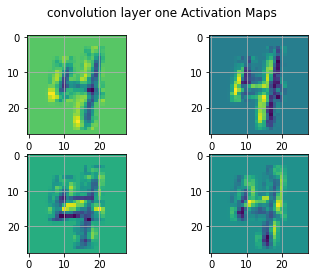

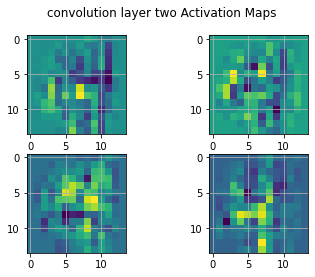

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


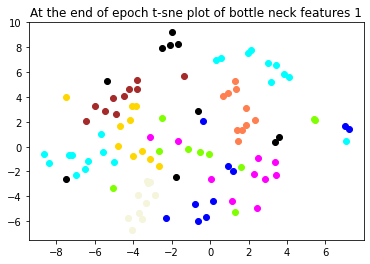


Epoch: 1 train loss: 2.30239 test loss: 2.30250 accuracy:  0.140
****************************************************************************************************************************


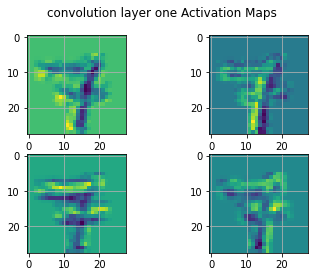

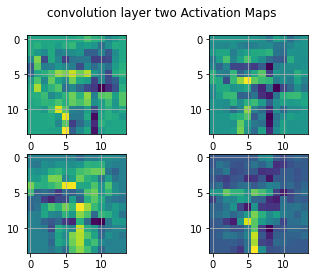


Epoch: 2 train loss: 2.30239 test loss: 2.30250 accuracy:  0.140
****************************************************************************************************************************


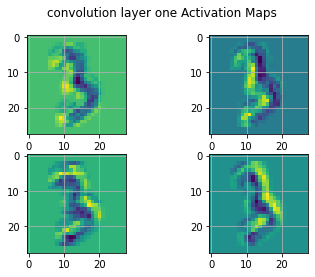

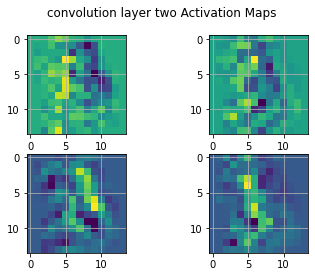


Epoch: 3 train loss: 2.30239 test loss: 2.30250 accuracy:  0.140
****************************************************************************************************************************


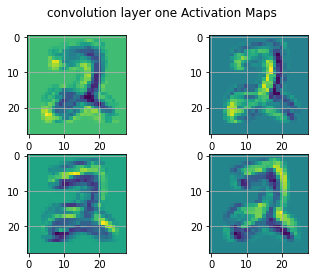

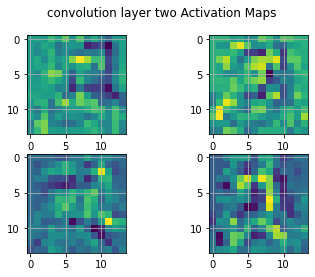


Epoch: 4 train loss: 2.30239 test loss: 2.30250 accuracy:  0.140
****************************************************************************************************************************


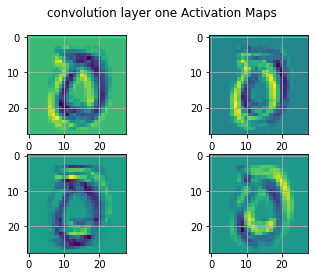

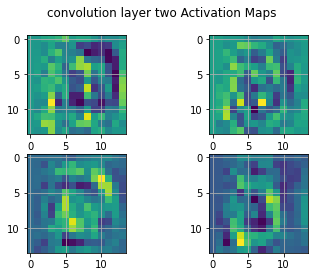


Epoch: 5 train loss: 2.30239 test loss: 2.30250 accuracy:  0.140
****************************************************************************************************************************


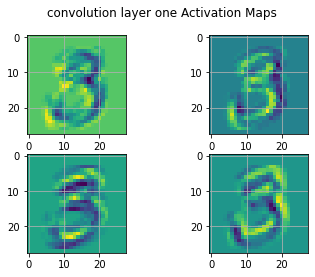

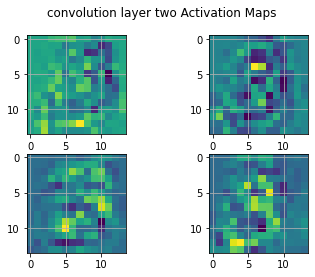


Epoch: 6 train loss: 2.30239 test loss: 2.30250 accuracy:  0.140
****************************************************************************************************************************


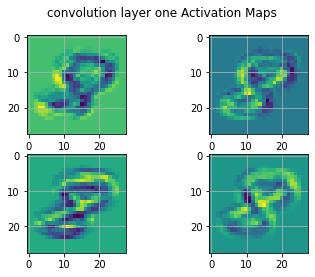

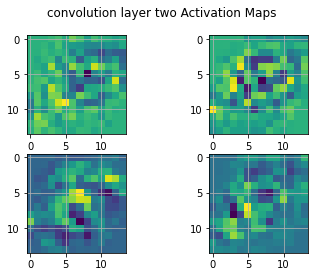


Epoch: 7 train loss: 2.30239 test loss: 2.30250 accuracy:  0.140
****************************************************************************************************************************


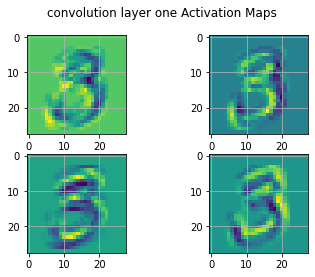

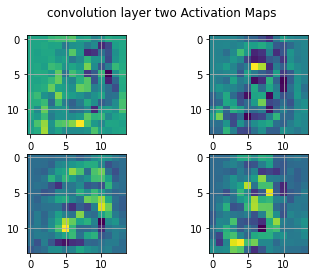


Epoch: 8 train loss: 2.30239 test loss: 2.30250 accuracy:  0.140
****************************************************************************************************************************


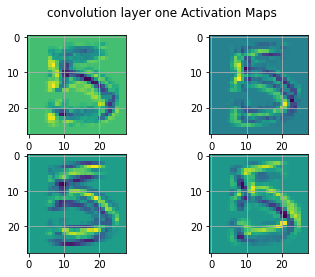

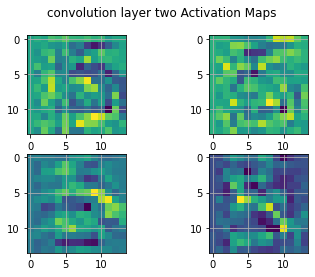


Epoch: 9 train loss: 2.30239 test loss: 2.30249 accuracy:  0.140
****************************************************************************************************************************


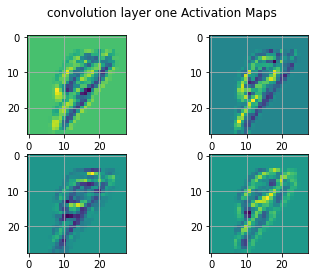

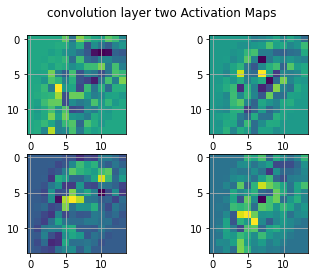


Epoch: 10 train loss: 2.30238 test loss: 2.30249 accuracy:  0.140
****************************************************************************************************************************


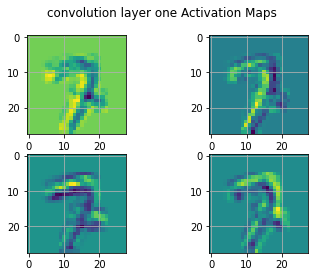

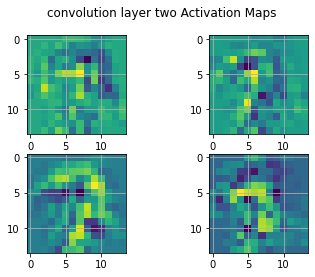


Epoch: 11 train loss: 2.30238 test loss: 2.30249 accuracy:  0.140
****************************************************************************************************************************


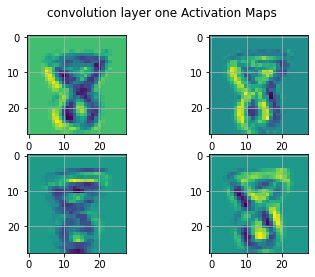

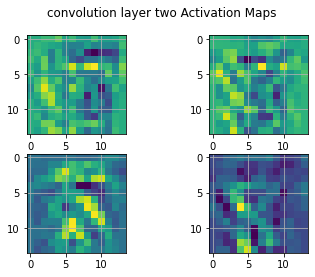


Epoch: 12 train loss: 2.30238 test loss: 2.30249 accuracy:  0.140
****************************************************************************************************************************


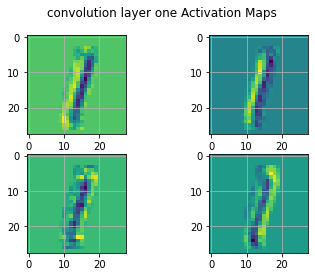

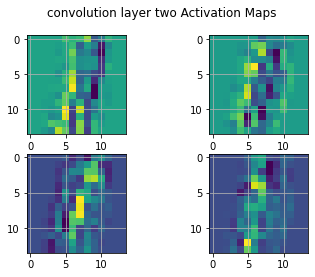


Epoch: 13 train loss: 2.30238 test loss: 2.30249 accuracy:  0.140
****************************************************************************************************************************


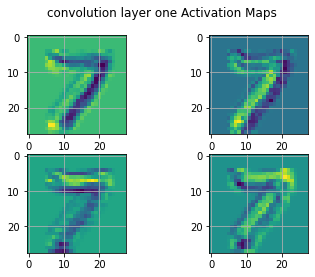

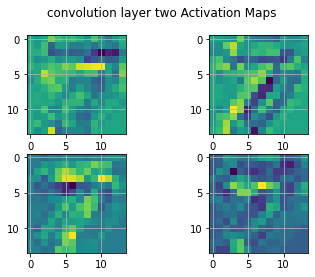


Epoch: 14 train loss: 2.30238 test loss: 2.30249 accuracy:  0.140
****************************************************************************************************************************


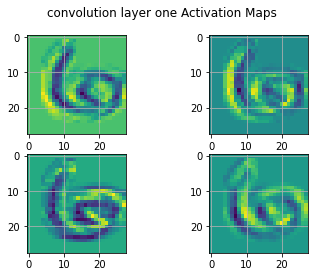

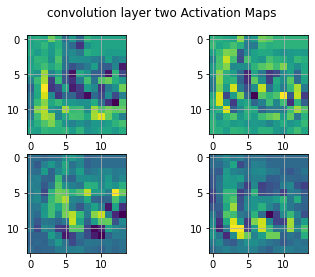

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


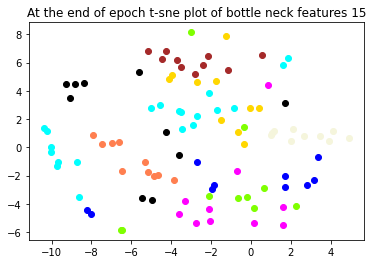


Epoch: 15 train loss: 2.30238 test loss: 2.30249 accuracy:  0.140
****************************************************************************************************************************
Training Completed!


In [ ]:
net = Net()
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
SgdTrainErrors, SgdTestErrors = TrainTest(net, criteria, optimizer)

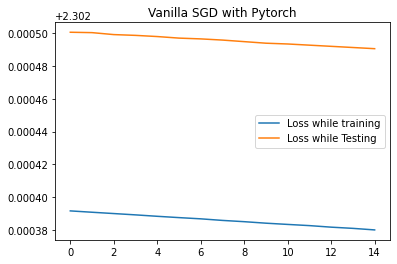

In [ ]:
LossPlot(SgdTrainErrors, SgdTestErrors, 'Vanilla SGD with Pytorch')

### Q2(b) Momentum

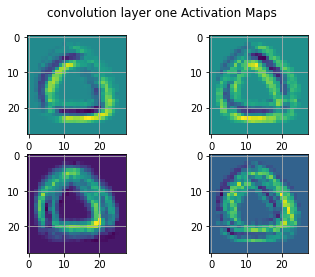

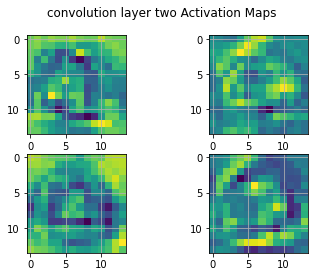

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


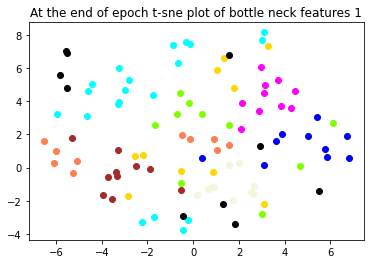


Epoch: 1 train loss: 2.30243 test loss: 2.30247 accuracy:  0.110
****************************************************************************************************************************


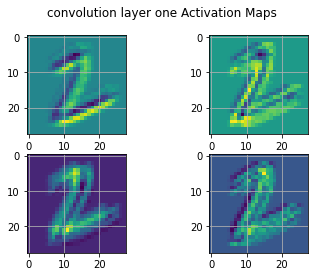

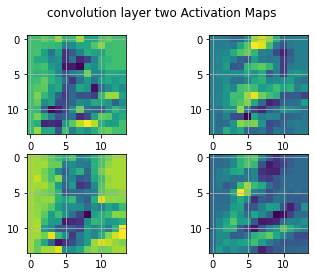


Epoch: 2 train loss: 2.30243 test loss: 2.30246 accuracy:  0.110
****************************************************************************************************************************


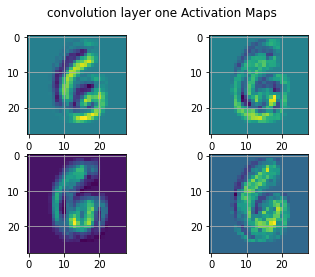

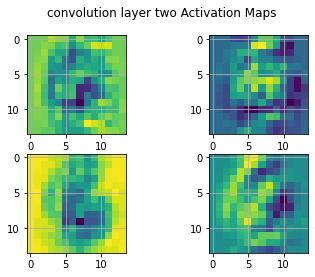


Epoch: 3 train loss: 2.30242 test loss: 2.30246 accuracy:  0.110
****************************************************************************************************************************


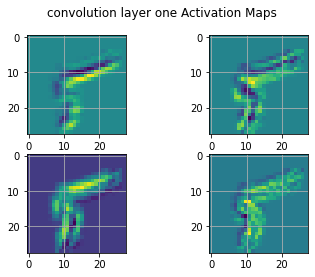

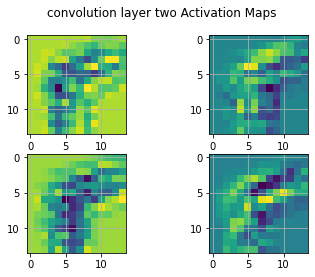


Epoch: 4 train loss: 2.30241 test loss: 2.30245 accuracy:  0.110
****************************************************************************************************************************


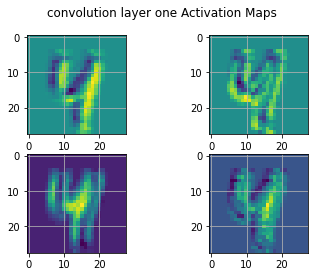

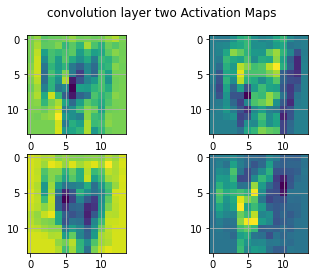


Epoch: 5 train loss: 2.30240 test loss: 2.30244 accuracy:  0.110
****************************************************************************************************************************


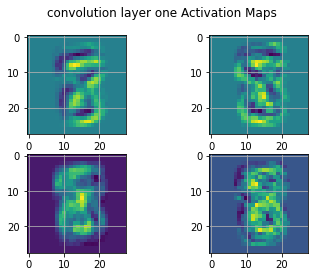

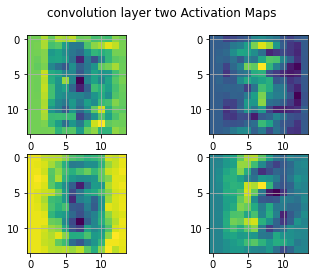


Epoch: 6 train loss: 2.30239 test loss: 2.30243 accuracy:  0.110
****************************************************************************************************************************


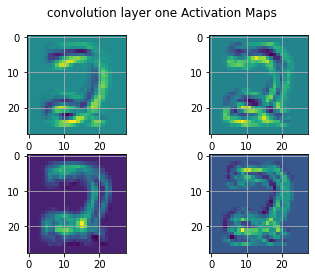

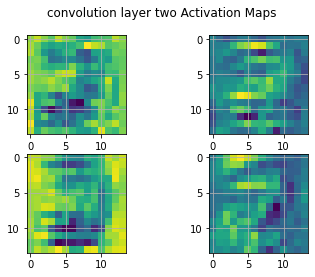


Epoch: 7 train loss: 2.30239 test loss: 2.30243 accuracy:  0.110
****************************************************************************************************************************


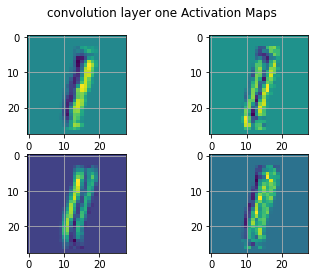

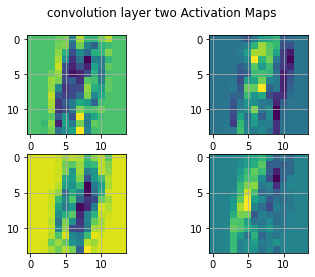


Epoch: 8 train loss: 2.30238 test loss: 2.30242 accuracy:  0.110
****************************************************************************************************************************


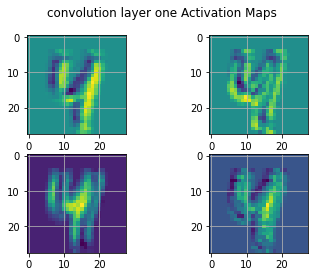

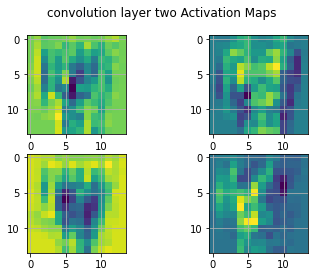


Epoch: 9 train loss: 2.30237 test loss: 2.30241 accuracy:  0.110
****************************************************************************************************************************


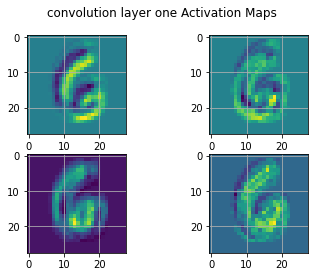

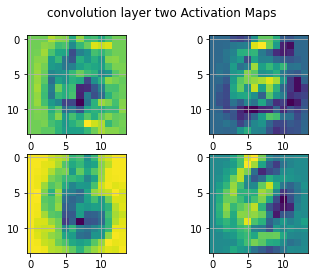


Epoch: 10 train loss: 2.30236 test loss: 2.30241 accuracy:  0.110
****************************************************************************************************************************


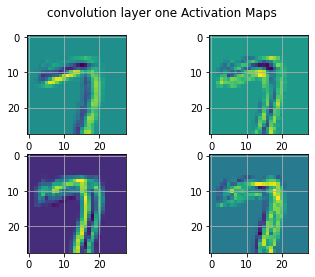

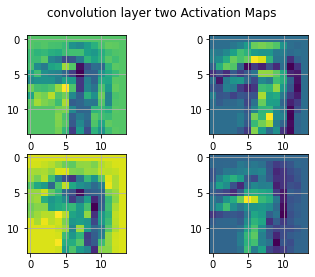


Epoch: 11 train loss: 2.30235 test loss: 2.30240 accuracy:  0.110
****************************************************************************************************************************


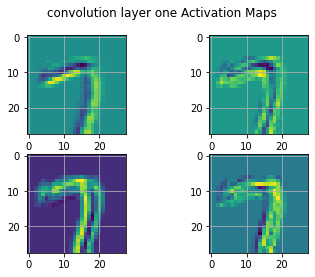

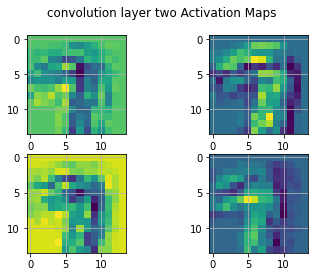


Epoch: 12 train loss: 2.30234 test loss: 2.30239 accuracy:  0.110
****************************************************************************************************************************


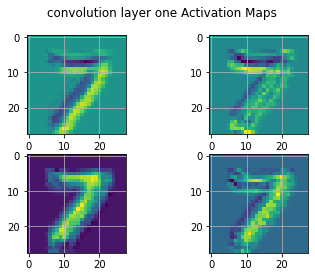

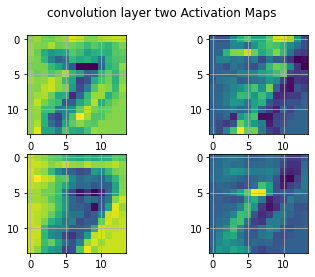


Epoch: 13 train loss: 2.30233 test loss: 2.30238 accuracy:  0.110
****************************************************************************************************************************


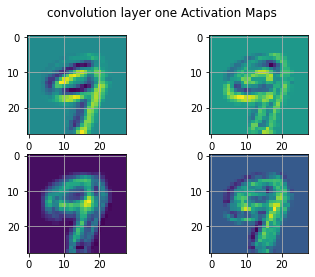

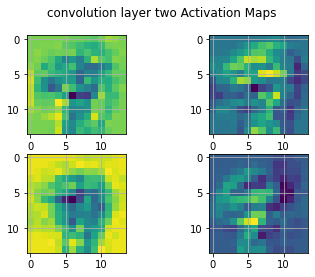


Epoch: 14 train loss: 2.30232 test loss: 2.30237 accuracy:  0.110
****************************************************************************************************************************


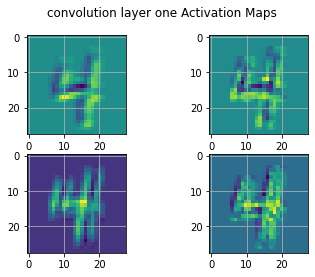

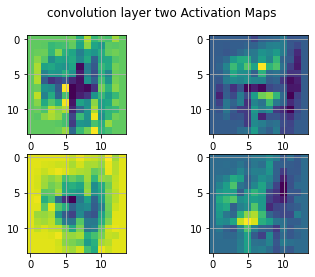

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


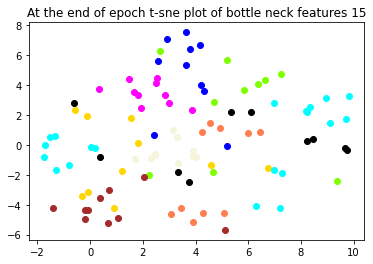


Epoch: 15 train loss: 2.30231 test loss: 2.30237 accuracy:  0.110
****************************************************************************************************************************
Training Completed!


In [ ]:
net = Net()
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
MomentumTrainErrors, MomentumTestErrors = TrainTest(net, criteria, optimizer)

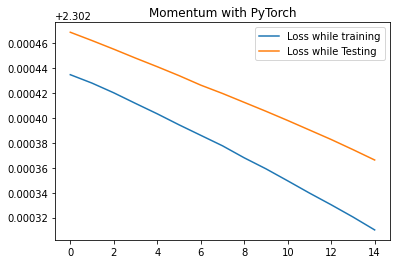

In [ ]:
LossPlot(MomentumTrainErrors, MomentumTestErrors, 'Momentum with PyTorch')

### Q2(c) RMS Prop

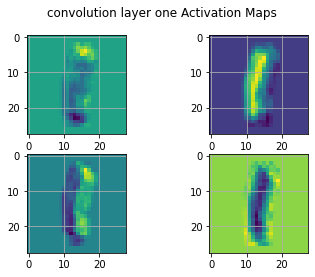

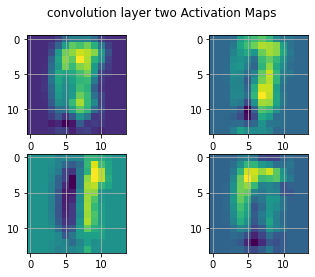

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


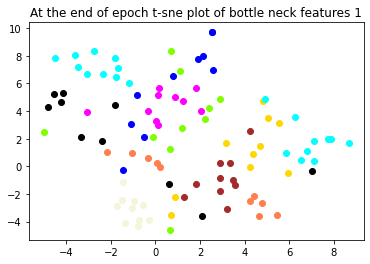


Epoch: 1 train loss: 2.29585 test loss: 2.27458 accuracy:  0.380
****************************************************************************************************************************


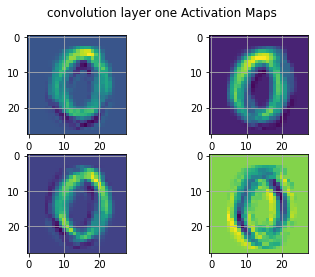

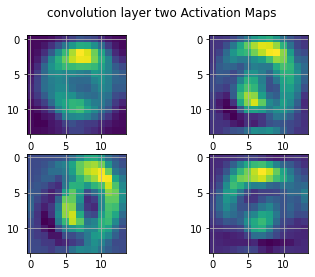


Epoch: 2 train loss: 2.19139 test loss: 2.09323 accuracy:  0.520
****************************************************************************************************************************


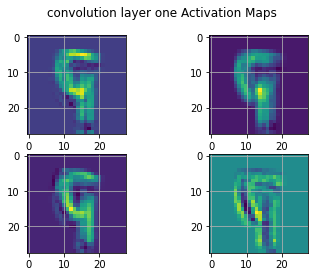

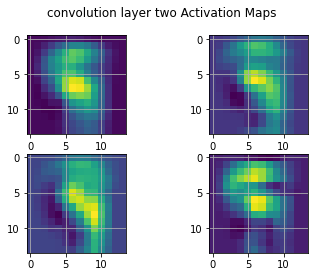


Epoch: 3 train loss: 1.96341 test loss: 1.91067 accuracy:  0.690
****************************************************************************************************************************


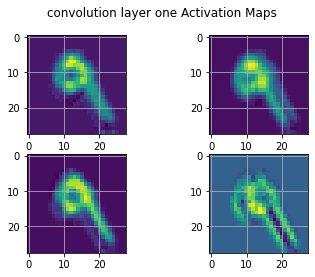

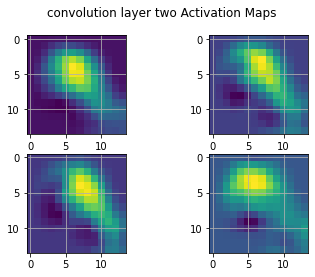


Epoch: 4 train loss: 1.80986 test loss: 1.82198 accuracy:  0.730
****************************************************************************************************************************


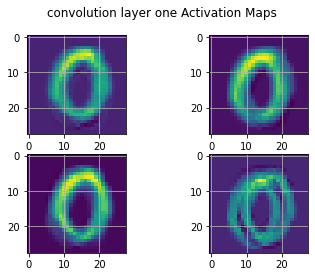

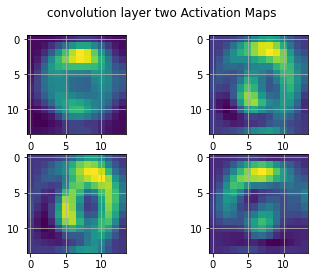


Epoch: 5 train loss: 1.74747 test loss: 1.75800 accuracy:  0.750
****************************************************************************************************************************


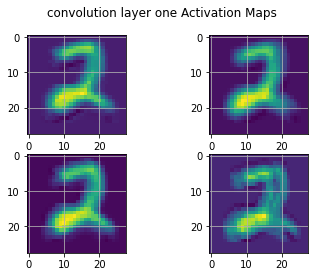

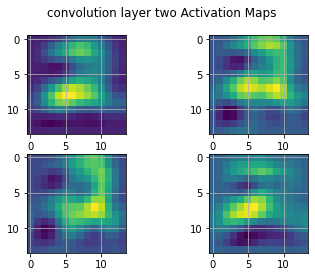


Epoch: 6 train loss: 1.70382 test loss: 1.72667 accuracy:  0.750
****************************************************************************************************************************


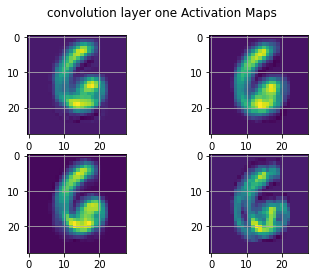

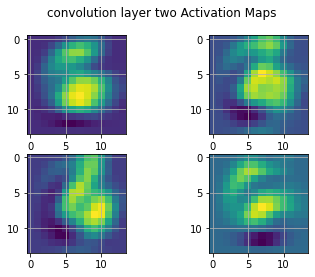


Epoch: 7 train loss: 1.67403 test loss: 1.69172 accuracy:  0.820
****************************************************************************************************************************


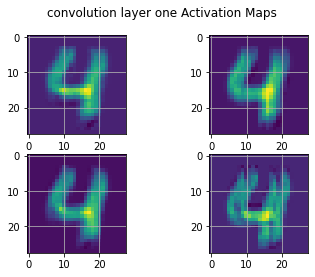

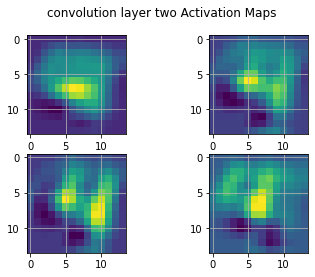


Epoch: 8 train loss: 1.64996 test loss: 1.68759 accuracy:  0.800
****************************************************************************************************************************


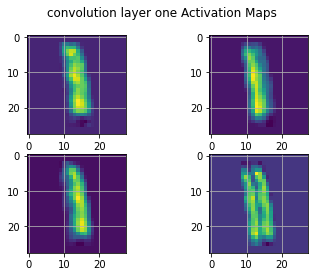

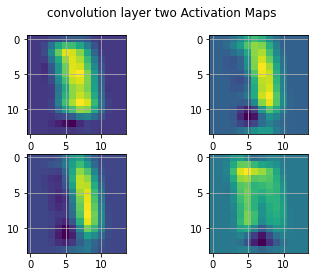


Epoch: 9 train loss: 1.63714 test loss: 1.64690 accuracy:  0.840
****************************************************************************************************************************


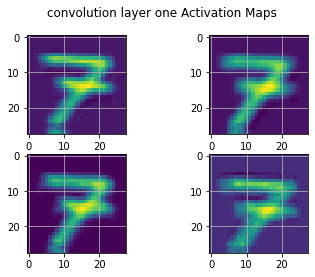

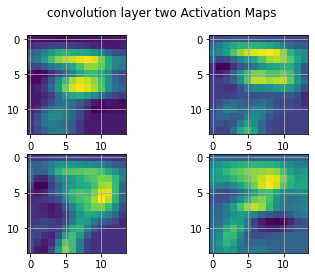


Epoch: 10 train loss: 1.62211 test loss: 1.65955 accuracy:  0.820
****************************************************************************************************************************


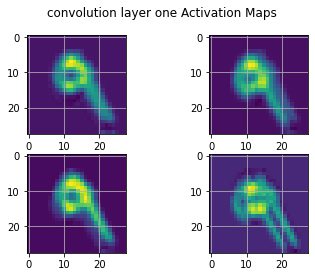

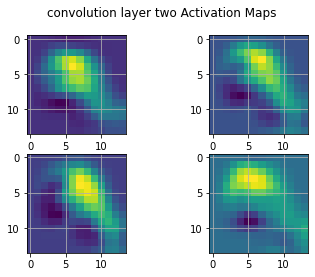


Epoch: 11 train loss: 1.61563 test loss: 1.62702 accuracy:  0.850
****************************************************************************************************************************


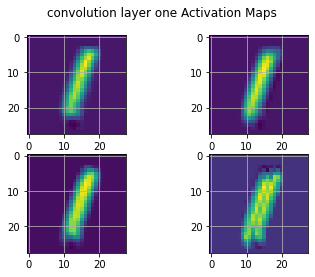

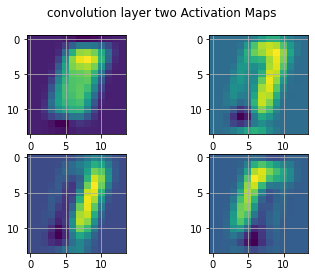


Epoch: 12 train loss: 1.60116 test loss: 1.67708 accuracy:  0.790
****************************************************************************************************************************


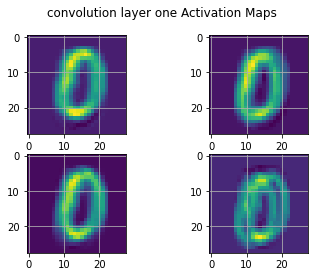

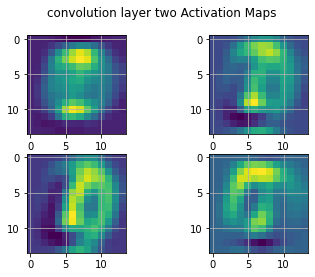


Epoch: 13 train loss: 1.59510 test loss: 1.63634 accuracy:  0.840
****************************************************************************************************************************


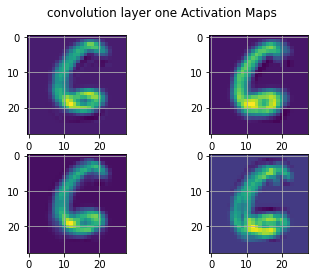

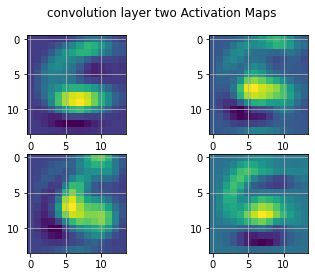


Epoch: 14 train loss: 1.59308 test loss: 1.60675 accuracy:  0.860
****************************************************************************************************************************


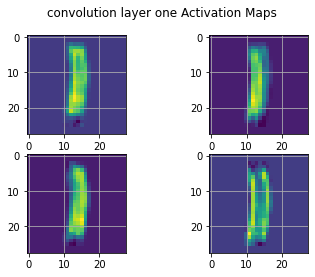

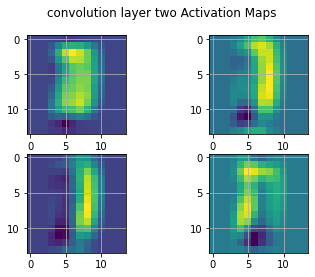

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


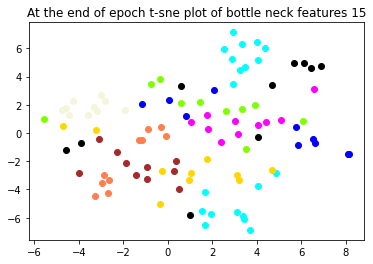


Epoch: 15 train loss: 1.57669 test loss: 1.60150 accuracy:  0.860
****************************************************************************************************************************
Training Completed!


In [ ]:
net = Net()
criteria = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.001, alpha=0.9)
RmsTrainErrors, RmsTestErrors = TrainTest(net, criteria, optimizer)

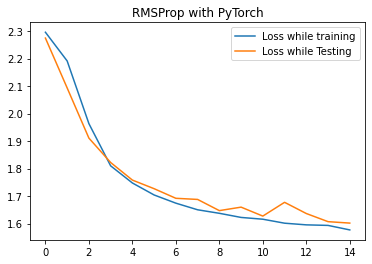

In [ ]:
LossPlot(RmsTrainErrors, RmsTestErrors, 'RMSProp with PyTorch')

### Applying Dropout

In [ ]:
class Net_with_dropout(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()
        self.convolutionOne = nn.Conv2d(1, 4, 5, padding=2, padding_mode='reflect')
        self.poolingOne = nn.MaxPool2d(2, 2)
        self.convolutiontwo = nn.Conv2d(4, 4, 5, padding=2, padding_mode='reflect')
        self.poolingtwo = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(7 * 7 * 4, 49)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(49, 10)

    def forward(self, x):                   
        x = self.poolingOne(F.relu(self.convolutionOne(x)))                                                 
        x = self.poolingtwo(F.relu(self.convolutiontwo(x)))                      
        x = torch.flatten(x, 1)       
        x = F.relu(self.fc1(x))     
        x = self.dropout(x)       
        x = F.softmax(self.fc2(x), dim=1)                    
        return x

In [ ]:
def TrainTest1(net, criteria, optimizer):
    ErrorsTrain = list()
    ErrorsTest = list()

    for epoch in range(15): 

        LossEpochTrain = 0.0
        for i, data in enumerate(Load_train, 0):
            inputs, labels = data                                 
            optimizer.zero_grad()
            outputs = net(inputs)                                                           
            _, preds = torch.max(outputs.data, 1)
            loss = criteria(outputs, labels)
            loss.backward()
            optimizer.step()
            LossEpochTrain += loss.item()                                                 
        LossEpochTrain /= i+1

        LossEpochTest = 0.0
        NcorrectTest = 0
        n = 0
        with torch.no_grad():
            for data in Load_test:
                images, labels = data
                outputs = net(images)                 
                _, preds = torch.max(outputs.data, 1)
                NcorrectTest += (preds == labels).sum().item()
                loss = criteria(outputs, labels)
                LossEpochTest += loss.item()   
                n += 1
            
        
        print(f'\nEpoch: {epoch + 1} Loss while training: {LossEpochTrain:.5f} Loss while Testing: {LossEpochTest/n:.5f} accuracy: {NcorrectTest/100: .3f}')
        print("****************************************************************************************************************************************************************************************************************************")
        ErrorsTrain.append(LossEpochTrain)
        ErrorsTest.append(LossEpochTest/n)

    print('Training got completed!')
    return ErrorsTrain, ErrorsTest

In [ ]:
# Dropout rates of 0.2, 0.5 and 0.8

NeuralNet1 = Net_with_dropout(0.2)
criteria = nn.CrossEntropyLoss()
optimizer1 = optim.RMSprop(NeuralNet1.parameters(), lr=0.001, alpha=0.9)
D2TrainErrors, D2TestErrors = TrainTest1(NeuralNet1, criteria, optimizer1)

NeuralNet2 = Net_with_dropout(0.5)
criteria = nn.CrossEntropyLoss()
optimizer2 = optim.RMSprop(NeuralNet2.parameters(), lr=0.001, alpha=0.9)
D5TrainErrors, D5TestErrors = TrainTest1(NeuralNet2, criteria, optimizer2)

NeuralNet3 = Net_with_dropout(0.8)
criteria = nn.CrossEntropyLoss()
optimizer3 = optim.RMSprop(NeuralNet3.parameters(), lr=0.001, alpha=0.9)
D8TrainErrors, D8TestErrors = TrainTest1(NeuralNet3, criteria, optimizer3)


Epoch: 1 Loss while training: 2.29751 Loss while Testing: 2.27951 accuracy:  0.260
****************************************************************************************************************************************************************************************************************************

Epoch: 2 Loss while training: 2.22898 Loss while Testing: 2.15126 accuracy:  0.410
****************************************************************************************************************************************************************************************************************************

Epoch: 3 Loss while training: 2.07057 Loss while Testing: 1.98273 accuracy:  0.590
****************************************************************************************************************************************************************************************************************************

Epoch: 4 Loss while training: 1.93561 Loss while Testing: 1.89757 accuracy:  0.630
*

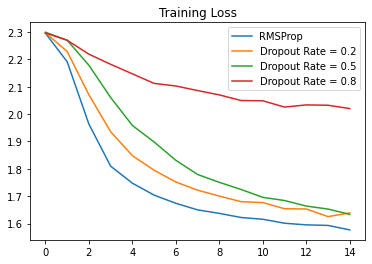

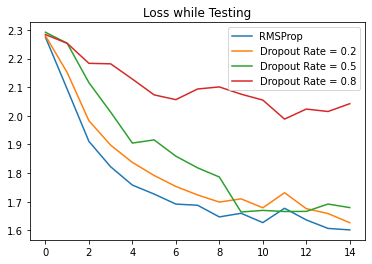

In [ ]:
plt.title('Training Loss')
plt.plot(range(15), RmsTrainErrors, label='RMSProp')
plt.plot(range(15), D2TrainErrors, label='Dropout Rate = 0.2')
plt.plot(range(15), D5TrainErrors, label='Dropout Rate = 0.5')
plt.plot(range(15), D8TrainErrors, label='Dropout Rate = 0.8')
plt.legend()
plt.show()

plt.title('Loss while Testing')
plt.plot(range(15), RmsTestErrors, label='RMSProp')
plt.plot(range(15), D2TestErrors, label='Dropout Rate = 0.2')
plt.plot(range(15), D5TestErrors, label='Dropout Rate = 0.5')
plt.plot(range(15), D8TestErrors, label='Dropout Rate = 0.8')
plt.legend()
plt.show()

### Batch Normalization

In [ ]:
class Net_BN(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolutionOne = nn.Conv2d(1, 4, 5, padding=2, padding_mode='reflect')
        self.poolingOne = nn.MaxPool2d(2, 2)
        self.convolutiontwo = nn.Conv2d(4, 4, 5, padding=2, padding_mode='reflect')
        self.poolingtwo = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(7 * 7 * 4, 49)
        self.bn = nn.BatchNorm1d(49)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(49, 10)

    def forward(self, x):                   
        x = self.poolingOne(F.relu(self.convolutionOne(x)))                                                 
        x = self.poolingtwo(F.relu(self.convolutiontwo(x)))                      
        x = torch.flatten(x, 1)   
        x = self.fc1(x) 
        x = self.bn(x)
        x = F.relu(x)     
        x = self.dropout(x)       
        x = self.fc2(x)
        x = F.softmax(x, dim=1)                    
        return x

In [ ]:
net = Net_BN()
criteria = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.001, alpha=0.9)
ErrorsTrain_bn, ErrorsTest_bn = TrainTest1(net, criteria, optimizer)


Epoch: 1 Loss while training: 2.17569 Loss while Testing: 2.07733 accuracy:  0.540
****************************************************************************************************************************************************************************************************************************

Epoch: 2 Loss while training: 2.00654 Loss while Testing: 1.98830 accuracy:  0.550
****************************************************************************************************************************************************************************************************************************

Epoch: 3 Loss while training: 1.91949 Loss while Testing: 1.92818 accuracy:  0.690
****************************************************************************************************************************************************************************************************************************

Epoch: 4 Loss while training: 1.84481 Loss while Testing: 1.82721 accuracy:  0.820
*

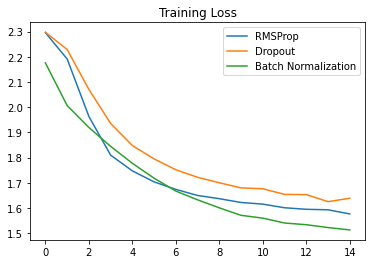

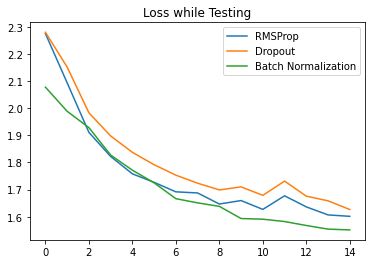

In [ ]:
plt.title('Training Loss')
plt.plot(range(15), RmsTrainErrors, label='RMSProp')
plt.plot(range(15), D2TrainErrors, label='Dropout')
plt.plot(range(15), ErrorsTrain_bn, label='Batch Normalization')
plt.legend()
plt.show()

plt.title('Loss while Testing')
plt.plot(range(15), RmsTestErrors, label='RMSProp')
plt.plot(range(15), D2TestErrors, label='Dropout')
plt.plot(range(15), ErrorsTest_bn, label='Batch Normalization')
plt.legend()
plt.show()

### Comparison with HW4 outputs

In [ ]:
class Module:


    def convolve(self, I, h, stride, padding, activation='relu', flip=True, verbose=True):

        W = np.shape(I)[0]
        H = np.shape(I)[1]
        C = np.shape(I)[2]

        k = np.shape(h)[0]  
       
        KernelFlipped = np.zeros([k, k, C])

        for i in range(C):
            x = h[:,:,i]
            x = x[:, ::-1]               # flipping about Y-axis
            x = x[::-1, :]               # flipping about X-axis
            KernelFlipped[:,:,i] = x

        ImagePadded = np.zeros([W + 2*padding, H + 2*padding, C])
        ImagePadded[padding: W+padding, padding: H+padding, :] = I

        # Reflection padding

        for c in range(C):
            Up = I[:, 1:padding+1, c]
            ImagePadded[padding:padding+W, 0:padding, c] = Up[::-1, :]

            below = I[:, H-padding-1:H-1, c]
            ImagePadded[padding:padding+W, padding+H:2*padding+H, c] = below[::-1, :]

            left = I[1:padding+1, :, c]
            ImagePadded[0:padding, padding:padding+H, c] = left[:, ::-1]

            right = I[W-padding-1:W-1, :, c]
            ImagePadded[padding+W:2*padding+W, padding:padding+H, c] = right[:, ::-1]

            UpLeft = ImagePadded[padding+1:2*padding+1, 0:padding, c]
            ImagePadded[0:padding, 0:padding, c] = UpLeft[:, ::-1]

            below_left = ImagePadded[padding+1:2*padding+1, padding+W:2*padding+W, c]
            ImagePadded[0:padding, padding+W:2*padding+W, c] = below_left[:, ::-1]

            UpRight = ImagePadded[W-1:padding+W-1, 0:padding, c]
            ImagePadded[padding+W:2*padding+W, 0:padding, c] = UpRight[:, ::-1]

            below_right = ImagePadded[W-1:padding+W-1, padding+W:2*padding+W, c]
            ImagePadded[padding+W:2*padding+W, padding+H:2*padding+H, c] = below_right[:, ::-1]

        W_1 = ImagePadded.shape[0]
        H_1 = ImagePadded.shape[1]
        res = list()

        for i in range(0, W_1-k+1, stride):
            row = list()
            for j in range(0, H_1-k+1, stride):
                if flip:
                    row.append(np.sum(ImagePadded[i:i+k, j:j+k, :] * KernelFlipped))
                else:
                    row.append(np.sum(ImagePadded[i:i+k, j:j+k, :] * h))
            res.append(row)
    
        convolutionImage = np.array([np.array(r) for r in res])
        activation_map = np.vectorize(eval('self.' + activation), otypes=[np.float64])(convolutionImage)

        return activation_map if verbose else convolutionImage
    
    
    def convolutionLayer(self, image, kernels, stride, padding, activation='relu', flip=True, verbose=True):

        k = kernels.shape[1]
        W = image.shape[0]
        H = image.shape[1]

        # padding = int((k - 1)/2) if pad else 0 

        W_1 = floor((W - k + 2*padding) / stride) + 1
        H_1 = floor((H - k + 2*padding) / stride) + 1
        output = np.zeros([W_1, H_1])

        for i in range(kernels.shape[0]):
            activation_map = self.convolve(image, kernels[i], stride=stride, padding=padding, activation=activation, flip=True, verbose=True)
            output = np.dstack((output, activation_map))

        output = output[:,:,1:]   
        return output


    def average(self, window):
        return np.mean(window.mean(axis=1))

    def maximum(self, window):
        return np.amax(window), np.unravel_index(window.argmax(), window.shape)


    def pooling(self, activation_map, pool_func, pool_window, stride):

        res = list(); res_ix = list()
        functionList = {'average': self.average, 'maximum': self.maximum}

        for i in range(0, activation_map.shape[0]-pool_window+1, stride):
            row = list(); row_ix = list()
            for j in range(0, activation_map.shape[1]-pool_window+1, stride):
                window = activation_map[i:i+pool_window, j:j+pool_window]
                args = {'window': window}
                val, ix = functionList[pool_func](**args)
                ix = [sum(x) for x in zip(ix, (i,j))]
                row.append(val); row_ix.append(ix)
            res.append(row); res_ix.append(row_ix)
        OutputPooled = np.array([np.array(r) for r in res])
        OutputPooled_idxs = np.array([np.array(r, dtype=object) for r in res_ix], dtype=object)

        return OutputPooled, OutputPooled_idxs


    def pooling_layer(self, output, pool_func, pool_window, stride):

        W_2 = floor((output.shape[0] - pool_window) / stride) + 1
        H_2 = floor((output.shape[1] - pool_window) / stride) + 1
        OutputPooled = np.zeros([W_2, H_2])
        OutputPooled_idxs = np.zeros([W_2, H_2])

        for i in range(output.shape[2]):
            x, x_ix = self.pooling(output[:,:,i], pool_func=pool_func, pool_window=pool_window, stride=stride)
            OutputPooled = np.dstack((OutputPooled, x))
            OutputPooled_idxs = np.dstack((OutputPooled_idxs, x_ix))
        OutputPooled = OutputPooled[:,:,1:]   
        OutputPooled_idxs = OutputPooled_idxs[:,:,1:]

        return OutputPooled, OutputPooled_idxs


    def flatten(self, OutputPooled, N):

        vec = list()
        for i in range(OutputPooled.shape[0]):
            for j in range(OutputPooled.shape[1]):
                vec.extend(OutputPooled[i,j,:])
        vec = np.array(vec)
        weights = np.identity(N, N)

        return weights.dot(vec)


    def relu(self, x):
        return max(0, x)


    def softmax(self, arr):
        # arr /= 10e6 
        denominator = 0
        res = np.zeros(arr.shape[0])
        for i in range(arr.shape[0]):
            res[i] = exp(arr[i])
            denominator += exp(arr[i])
        res /= denominator
        return res


    def fc_layer(self, x, weights, activation):

        z = weights.dot(x)
        if activation == 'softmax':
           
            a = self.softmax(z)
        else:
            a = np.vectorize(eval('self.' + activation), otypes=[np.float64])(z)
        return z, a

In [ ]:
class Net_HW4(Module):

    def __init__(self):
      
        self.convolutionOne_kernels = np.random.uniform(low=-1/28, high=1/28, size=(4, 5, 5, 1))
        self.convolutiontwo_kernels = np.random.uniform(low=-1/28, high=1/28, size=(4, 5, 5, 4))
        self.fc_layers = [196, 49, 10]
        self.weights = dict()
        self.weights[0] = np.random.uniform(low=-1/196, high=1/196, size=(49,196))
        self.weights[1] = np.random.uniform(low=-1/49, high=1/49, size=(10, 49))
      


    def forward(self, image):
        self.conv_op1 = super().convolutionLayer(image, self.convolutionOne_kernels, stride=1, padding=2, activation='relu')
        self.pooled_op1, self.pooled_op1_idxs = super().pooling_layer(self.conv_op1, pool_func="maximum", pool_window=2, stride=2)
        self.conv_op2 = super().convolutionLayer(self.pooled_op1, self.convolutiontwo_kernels, stride=1, padding=2, activation='relu')
        self.pooled_op2, self.pooled_op2_idxs = super().pooling_layer(self.conv_op2, pool_func="maximum", pool_window=2, stride=2)
        self.a_1 = super().flatten(self.pooled_op2, np.prod(self.pooled_op2.shape))
        self.z_2, self.a_2 = super().fc_layer(self.a_1, self.weights[0], activation='relu')
        self.z_3, self.a_3 = super().fc_layer(self.a_2, self.weights[1], activation='softmax')		
        return self.a_3


    def CrossEntorpy(self, y, yHat):
        loss = 0
        for i in range(len(y)):
            s = -(y[i] * log2(yHat[i]))
            loss += s
        return loss

In [ ]:
def inflate(delta, pooled_ix, op):
    DeltaInflated = np.zeros_like(op)
    for i in range(pooled_ix.shape[0]):
        for j in range(pooled_ix.shape[1]):
            cnt = 0
            for k in range(0, pooled_ix.shape[2]-1, 2):
                x, y = pooled_ix[i][j][k], pooled_ix[i][j][k+1]
                DeltaInflated[x][y][cnt] = delta[i][j][cnt]
                cnt += 1
    return DeltaInflated

In [ ]:
batch_size = 40
learning_rate = 0.001
alpha = 0.9
rho = 0.9

In [ ]:
def SelfTrainTest(net, varaintSGD):
    
    train_loss = list()
    test_loss = list()

    for epoch in range(15):
        print("\n\nEpoch: " + str(epoch))
        LossEpochTrain = 0
        LossEpochTest = 0
        n_corr_train = 0
        NcorrectTest = 0

        if varaintSGD == 'momentum':
            v_gradientfcone = np.zeros((49,196))
            v_gradientfctwo = np.zeros((10,49))
            v_grad_convolutionOne = np.zeros((4,5,5,1))
            v_grad_convolutiontwo = np.zeros((4,5,5,4))
        
        if varaintSGD == 'rms':
            g_gradientfcone = np.zeros((49,196))
            g_gradientfctwo = np.zeros((10,49))
            g_grad_convolutionOne = np.zeros((4,5,5,1))
            g_grad_convolutiontwo = np.zeros((4,5,5,4))
        
        
        # TRAIN
        
        for (batchIdx, batch) in enumerate(Load_train): 
            print("MiniBatch processing: " + str(batchIdx))
            images, labels = batch

            batch_train_loss = 0

            gradientfcone = np.zeros((49,196)); gradientfcone_sq = np.zeros((49,196))
            gradientfctwo = np.zeros((10,49)); gradientfctwo_sq = np.zeros((10,49))
            grad_convolutionOne = np.zeros((4,5,5,1)); grad_convolutionOne_sq = np.zeros((4,5,5,1))
            grad_convolutiontwo = np.zeros((4,5,5,4)); grad_convolutiontwo_sq = np.zeros((4,5,5,4))

            for (image, label) in zip(images, labels): 
                image = np.array(image).reshape(28, 28, 1)
                yHat = net.forward(image)
                y = np.zeros(10); y[int(label)] = 1                                          
                batch_train_loss += net.CrossEntorpy(y, yHat)

                
                if yHat.argmax() == int(label):
                    n_corr_train += 1

                deltaFCtwo = -y/(yHat * log(2))
                gradientfctwo_sample = np.zeros((10, 49))
                for r in range(10):
                    for c in range(49):
                        gradientfctwo_sample[r][c] = net.a_2[c] * yHat[r] * (1-yHat[r]) * deltaFCtwo[r]


                deltaFCone = np.dot(net.weights[1].T, deltaFCtwo)
                gradientfcone_sample = np.zeros((49, 196))
                for r in range(49):
                    for c in range(196):
                        if net.z_2[r]:
                            gradientfcone_sample[r][c] = net.a_1[c] * deltaFCone[r]                       # can be done with outer product


                deltaFCip = np.dot(net.weights[0].T, deltaFCone)
                deltaFCip = deltaFCip.reshape(7, 7, 4)
                delta_convolutiontwo_op = inflate(deltaFCip, net.pooled_op2_idxs, net.conv_op2)
                grad_convolutiontwo_sample = np.zeros((4,5,5,4))
                for i in range(4):                                                       # number of kernels in conv 2
                    k = np.zeros((5,5))
                    for j in range(4):                                 # number of channels in padded image 18 x 18 x 4
                        k = np.dstack((k, net.convolve(net.pooled_op1[:,:,j].reshape(14,14,1), delta_convolutiontwo_op[:,:,i].reshape(14,14,1), stride=1, padding = 2, flip=True, 		  verbose=False)))

                    grad_convolutiontwo_sample[i] = k[:,:,1:]                                     # 5 x 5 x 4

                delta_pooled_op1 = net.convolutionLayer(delta_convolutiontwo_op, net.convolutiontwo_kernels, stride=1, padding=2, flip=False, verbose=False)     	# 14 x 14 x 4				

                delta_convolutionOne_op = inflate(delta_pooled_op1, net.pooled_op1_idxs, net.conv_op1)

                grad_convolutionOne_sample = np.zeros((4,5,5,1))
                for i in range(4):                                                       # number of kernels in conv 1
                    x = net.convolve(image, delta_convolutionOne_op[:,:,i].reshape(28,28,1), stride=1, padding=2, flip=True, verbose=False)		# 5 x 5 x 1
                    grad_convolutionOne_sample[i] = x.reshape(5,5,1)

                gradientfcone += gradientfcone_sample
                gradientfctwo += gradientfctwo_sample
                grad_convolutionOne += grad_convolutionOne_sample
                grad_convolutiontwo += grad_convolutiontwo_sample
                
                gradientfcone_sq += np.square(gradientfcone_sample)
                gradientfctwo_sq += np.square(gradientfctwo_sample)
                grad_convolutionOne_sq += np.square(grad_convolutionOne_sample)
                grad_convolutiontwo_sq += np.square(grad_convolutiontwo_sample)


            

            gradientfcone /= batch_size; gradientfcone_sq /= batch_size
            gradientfctwo /= batch_size; gradientfctwo_sq /= batch_size
            grad_convolutionOne /= batch_size; grad_convolutionOne_sq /= batch_size
            grad_convolutiontwo /= batch_size; grad_convolutiontwo_sq /= batch_size

            batch_train_loss /= batch_size
            LossEpochTrain += batch_train_loss

            # Weight Update

            # vanilla SGD
            if varaintSGD == 'vanilla':
                net.weights[0] = net.weights[0] - learning_rate * (gradientfcone)
                net.weights[1] = net.weights[1] - learning_rate * (gradientfctwo)
                net.convolutionOne_kernels = net.convolutionOne_kernels - learning_rate * (grad_convolutionOne)
                net.convolutiontwo_kernels = net.convolutiontwo_kernels - learning_rate * (grad_convolutiontwo)

            # Momentum
            if varaintSGD == 'momentum':
                v_gradientfcone_new = alpha * v_gradientfcone - learning_rate * gradientfcone
                v_gradientfctwo_new = alpha * v_gradientfctwo - learning_rate * gradientfctwo
                v_grad_convolutionOne_new = alpha * v_grad_convolutionOne - learning_rate * grad_convolutionOne
                v_grad_convolutiontwo_new = alpha * v_grad_convolutiontwo - learning_rate * grad_convolutiontwo

                v_gradientfcone = v_gradientfcone_new[:,:]
                v_gradientfctwo = v_gradientfctwo_new[:,:]
                v_grad_convolutionOne = v_grad_convolutionOne_new[:,:,:,:]
                v_grad_convolutiontwo = v_grad_convolutiontwo_new[:,:,:,:]

                net.weights[0] = net.weights[0] + v_gradientfcone
                net.weights[1] = net.weights[1] + v_gradientfctwo
                net.convolutionOne_kernels = net.convolutionOne_kernels + v_grad_convolutionOne
                net.convolutiontwo_kernels = net.convolutiontwo_kernels + v_grad_convolutiontwo

            # RMS Prop
            if varaintSGD == 'rms':
                g_gradientfcone_new = rho * g_gradientfcone + (1-rho) * gradientfcone_sq
                g_gradientfctwo_new = rho * g_gradientfctwo + (1-rho) * gradientfctwo_sq
                g_grad_convolutionOne_new = rho * g_grad_convolutionOne + (1-rho) * grad_convolutionOne_sq
                g_grad_convolutiontwo_new = rho * g_grad_convolutiontwo + (1-rho) * grad_convolutiontwo_sq

                g_gradientfcone = g_gradientfcone_new[:,:]
                g_gradientfctwo = g_gradientfctwo_new[:,:]
                g_grad_convolutionOne = g_grad_convolutionOne_new[:,:,:,:]
                g_grad_convolutiontwo = g_grad_convolutiontwo_new[:,:,:,:]    
                
                stabilizing_const = 10e-8
                
                net.weights[0] = net.weights[0] - (learning_rate * np.sqrt(gradientfcone_sq))/np.sqrt(stabilizing_const + g_gradientfcone_new)
                net.weights[1] = net.weights[1] - (learning_rate * np.sqrt(gradientfctwo_sq))/np.sqrt(stabilizing_const + g_gradientfctwo_new)
                net.convolutionOne_kernels = net.convolutionOne_kernels - (learning_rate * np.sqrt(grad_convolutionOne_sq))/np.sqrt(stabilizing_const + g_grad_convolutionOne_new)
                net.convolutiontwo_kernels = net.convolutiontwo_kernels - (learning_rate * np.sqrt(grad_convolutiontwo_sq))/np.sqrt(stabilizing_const + g_grad_convolutiontwo_new)
                

            
            
        noofBatchesTrain = batchIdx + 1    
            
        # TEST
        features = np.zeros(196)
        
        for (batchIdx, batch) in enumerate(Load_test): 
            images, labels = batch
            TestLossOfBatch = 0
            for (image, label) in zip(images, labels): 
                image = np.array(image).reshape(28, 28, 1)
                yHat = net.forward(image)
                y = np.zeros(10); y[int(label)] = 1                                          
                TestLossOfBatch += net.CrossEntorpy(y, yHat)
                
                if yHat.argmax() == int(label):
                    NcorrectTest += 1
                    
                features = np.vstack([features, net.a_1])
                    
                    
            TestLossOfBatch /= batch_size
            LossEpochTest += TestLossOfBatch
           
        # Visualize activation maps 
        output2 = net.conv_op2
        z = output2.shape[2]
        NoofRows = ceil(z/2) if z%2 else z/2
        plt.suptitle("Activation Maps")
        for i in range(z):
            plt.subplot(int(NoofRows), 2, i+1)
            plt.imshow(output2[:,:,i])
            plt.grid(True)
        plt.show()        
        
        noofBatchesTest = batchIdx + 1
            
        LossEpochTrain /= noofBatchesTrain
        LossEpochTest /= noofBatchesTest
        
        train_loss.append(LossEpochTrain)
        test_loss.append(LossEpochTest)
        
        print("Training Loss: " + str(LossEpochTrain))
        print("Training Accuracy: " + str(n_corr_train/1000))
        print("Loss while Testing: " + str(LossEpochTest))
        print("Test Accuracy: " + str(NcorrectTest/100))

    print('Execution Completed!')
    return train_loss, test_loss



Epoch: 0
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


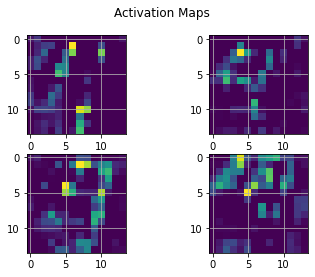

Training Loss: 3.321928289629598
Training Accuracy: 0.086
Loss while Testing: 8.304820866107686
Test Accuracy: 0.06


Epoch: 1
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


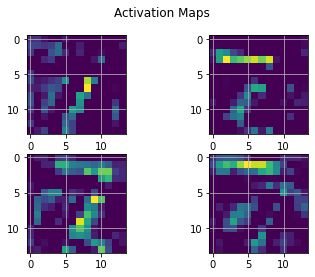

Training Loss: 3.321928249151057
Training Accuracy: 0.086
Loss while Testing: 8.304820769167659
Test Accuracy: 0.06


Epoch: 2
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


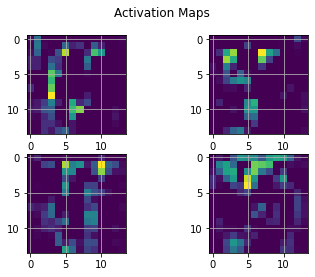

Training Loss: 3.3219282140603057
Training Accuracy: 0.089
Loss while Testing: 8.304820691702025
Test Accuracy: 0.06


Epoch: 3
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


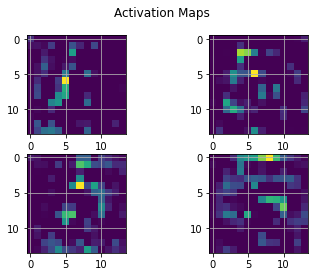

Training Loss: 3.321928173410379
Training Accuracy: 0.087
Loss while Testing: 8.304820620361102
Test Accuracy: 0.06


Epoch: 4
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


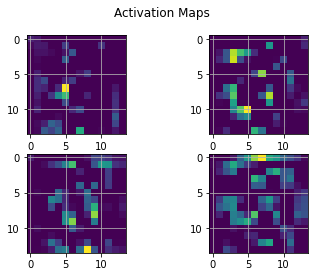

Training Loss: 3.3219281455504914
Training Accuracy: 0.088
Loss while Testing: 8.304820558824654
Test Accuracy: 0.06


Epoch: 5
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


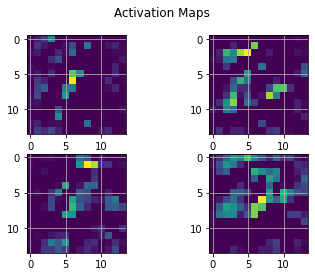

Training Loss: 3.3219281139711843
Training Accuracy: 0.091
Loss while Testing: 8.304820497882963
Test Accuracy: 0.06


Epoch: 6
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


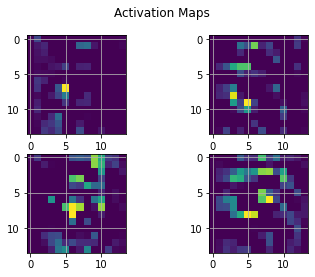

Training Loss: 3.321928086295507
Training Accuracy: 0.089
Loss while Testing: 8.304820425393762
Test Accuracy: 0.06


Epoch: 7
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


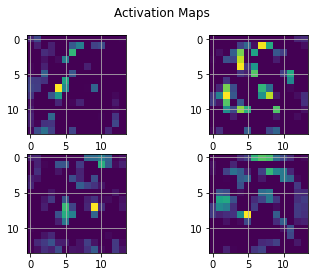

Training Loss: 3.3219280575523786
Training Accuracy: 0.093
Loss while Testing: 8.30482035351891
Test Accuracy: 0.06


Epoch: 8
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


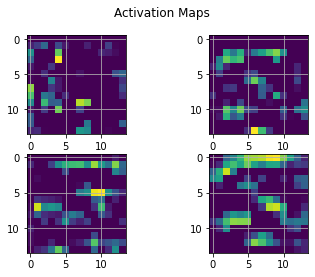

Training Loss: 3.3219280258028276
Training Accuracy: 0.096
Loss while Testing: 8.30482029381473
Test Accuracy: 0.07


Epoch: 9
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


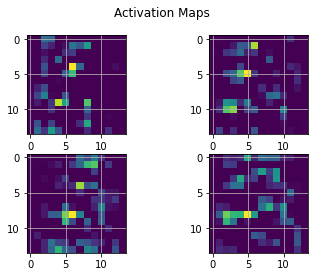

Training Loss: 3.321927998940671
Training Accuracy: 0.097
Loss while Testing: 8.304820236526695
Test Accuracy: 0.08


Epoch: 10
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


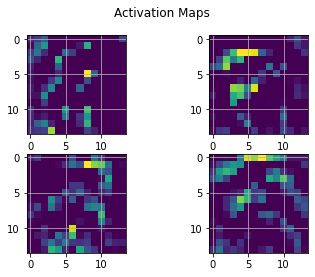

Training Loss: 3.3219279724413253
Training Accuracy: 0.099
Loss while Testing: 8.304820177235673
Test Accuracy: 0.08


Epoch: 11
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


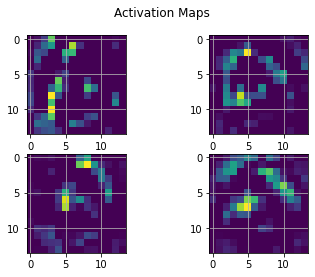

Training Loss: 3.321927948325357
Training Accuracy: 0.099
Loss while Testing: 8.304820120276649
Test Accuracy: 0.08


Epoch: 12
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


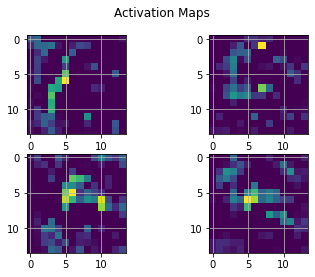

Training Loss: 3.321927929489617
Training Accuracy: 0.099
Loss while Testing: 8.304820059791748
Test Accuracy: 0.08


Epoch: 13
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


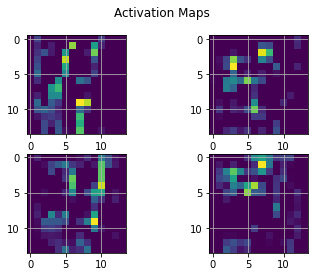

Training Loss: 3.3219279081985076
Training Accuracy: 0.099
Loss while Testing: 8.304819994542763
Test Accuracy: 0.08


Epoch: 14
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


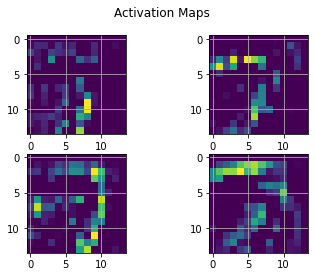

Training Loss: 3.321927888141066
Training Accuracy: 0.095
Loss while Testing: 8.304819948758494
Test Accuracy: 0.08
Execution Completed!


In [ ]:
net = Net_HW4()
train_loss_self_sgd, test_loss_self_sgd = SelfTrainTest(net, varaintSGD = 'vanilla')



Epoch: 0
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


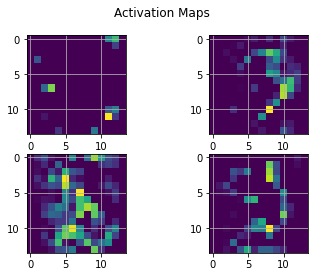

Training Loss: 3.321927849401393
Training Accuracy: 0.094
Loss while Testing: 8.304821789987338
Test Accuracy: 0.09


Epoch: 1
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


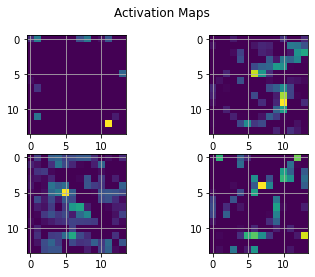

Training Loss: 3.3219278079608436
Training Accuracy: 0.092
Loss while Testing: 8.30482145079446
Test Accuracy: 0.1


Epoch: 2
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


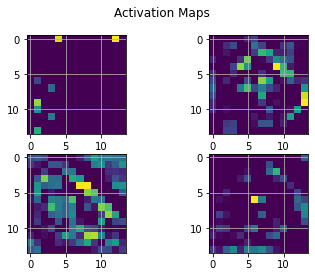

Training Loss: 3.3219278014292595
Training Accuracy: 0.092
Loss while Testing: 8.304821115958996
Test Accuracy: 0.1


Epoch: 3
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


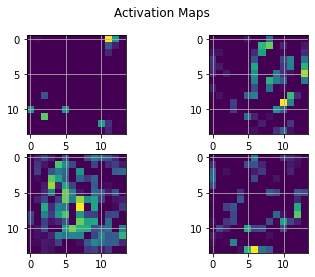

Training Loss: 3.3219277751226706
Training Accuracy: 0.09
Loss while Testing: 8.304820893161901
Test Accuracy: 0.08


Epoch: 4
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


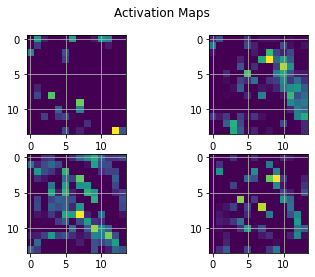

Training Loss: 3.321927757043698
Training Accuracy: 0.093
Loss while Testing: 8.304820731157559
Test Accuracy: 0.1


Epoch: 5
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


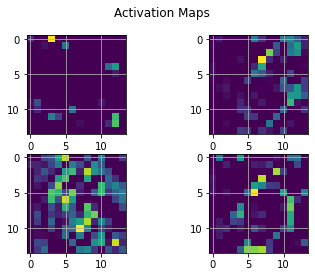

Training Loss: 3.321927773504419
Training Accuracy: 0.092
Loss while Testing: 8.304820565939647
Test Accuracy: 0.09


Epoch: 6
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


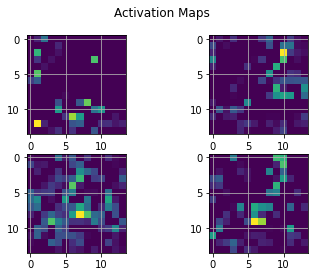

Training Loss: 3.321927787968861
Training Accuracy: 0.092
Loss while Testing: 8.304820353997531
Test Accuracy: 0.11


Epoch: 7
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


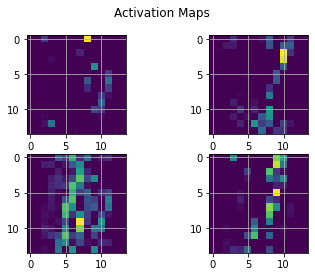

Training Loss: 3.3219277952715953
Training Accuracy: 0.097
Loss while Testing: 8.304820100654801
Test Accuracy: 0.12


Epoch: 8
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


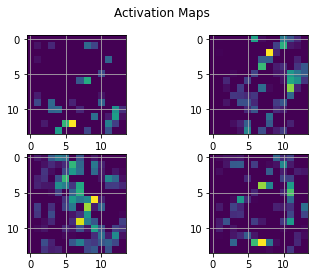

Training Loss: 3.3219277954176256
Training Accuracy: 0.102
Loss while Testing: 8.3048198900283
Test Accuracy: 0.13


Epoch: 9
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


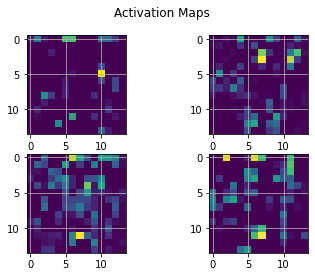

Training Loss: 3.321927800841972
Training Accuracy: 0.108
Loss while Testing: 8.304819732631717
Test Accuracy: 0.13


Epoch: 10
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


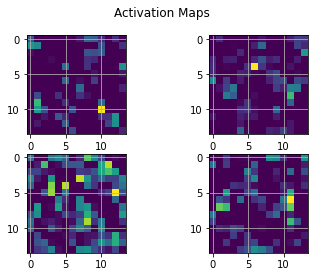

Training Loss: 3.3219278191139567
Training Accuracy: 0.108
Loss while Testing: 8.304819655647368
Test Accuracy: 0.14


Epoch: 11
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


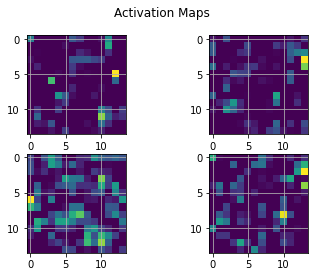

Training Loss: 3.321927827922001
Training Accuracy: 0.107
Loss while Testing: 8.304819620453978
Test Accuracy: 0.13


Epoch: 12
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


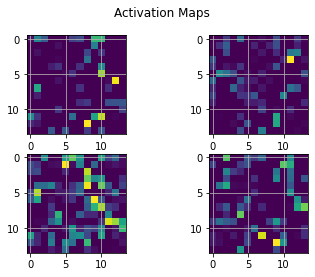

Training Loss: 3.3219278549860576
Training Accuracy: 0.105
Loss while Testing: 8.304819619311775
Test Accuracy: 0.15


Epoch: 13
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


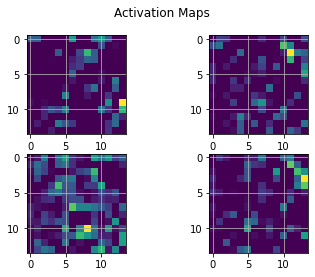

Training Loss: 3.3219278857311365
Training Accuracy: 0.105
Loss while Testing: 8.30481967710644
Test Accuracy: 0.16


Epoch: 14
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


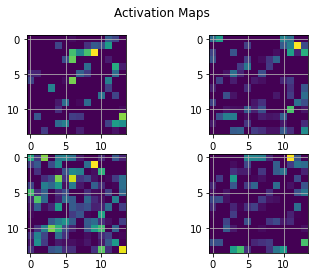

Training Loss: 3.321927907992681
Training Accuracy: 0.105
Loss while Testing: 8.304819723456145
Test Accuracy: 0.14
Execution Completed!


In [ ]:
net = Net_HW4()
train_loss_self_m, test_loss_self_m = SelfTrainTest(net, varaintSGD = 'momentum')



Epoch: 0
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


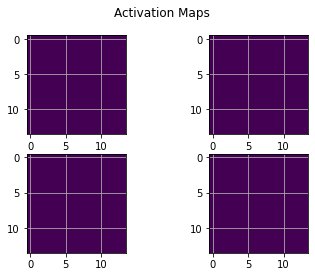

Training Loss: 3.321928020736477
Training Accuracy: 0.1
Loss while Testing: 8.304820237218419
Test Accuracy: 0.1


Epoch: 1
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


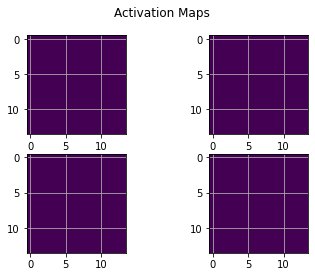

Training Loss: 3.321928094887367
Training Accuracy: 0.1
Loss while Testing: 8.304820237218419
Test Accuracy: 0.1


Epoch: 2
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


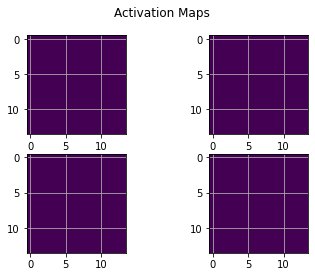

Training Loss: 3.321928094887367
Training Accuracy: 0.1
Loss while Testing: 8.304820237218419
Test Accuracy: 0.1


Epoch: 3
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


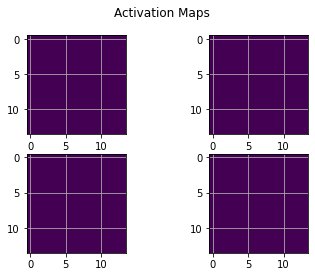

Training Loss: 3.321928094887367
Training Accuracy: 0.1
Loss while Testing: 8.304820237218419
Test Accuracy: 0.1


Epoch: 4
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


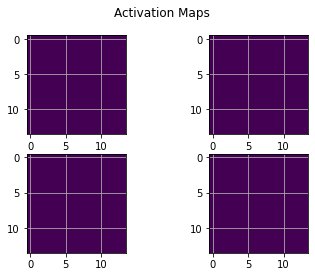

Training Loss: 3.321928094887367
Training Accuracy: 0.1
Loss while Testing: 8.304820237218419
Test Accuracy: 0.1


Epoch: 5
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


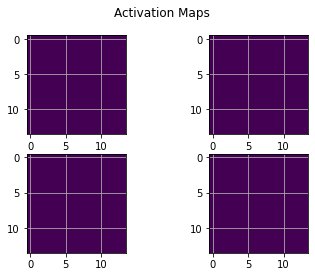

Training Loss: 3.321928094887367
Training Accuracy: 0.1
Loss while Testing: 8.304820237218419
Test Accuracy: 0.1


Epoch: 6
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


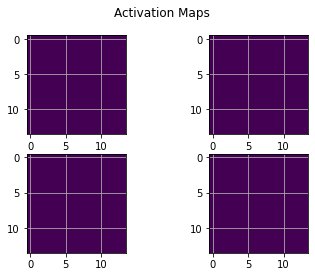

Training Loss: 3.321928094887367
Training Accuracy: 0.1
Loss while Testing: 8.304820237218419
Test Accuracy: 0.1


Epoch: 7
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


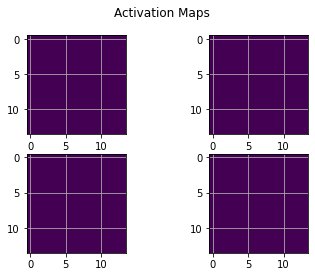

Training Loss: 3.321928094887367
Training Accuracy: 0.1
Loss while Testing: 8.304820237218419
Test Accuracy: 0.1


Epoch: 8
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


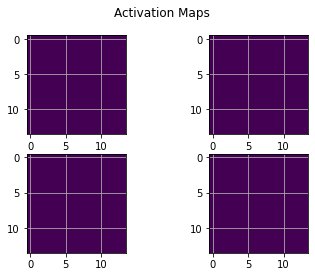

Training Loss: 3.321928094887367
Training Accuracy: 0.1
Loss while Testing: 8.304820237218419
Test Accuracy: 0.1


Epoch: 9
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


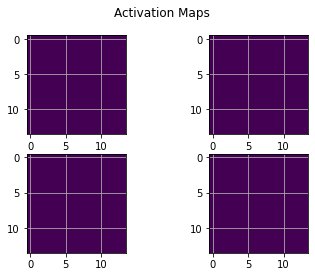

Training Loss: 3.321928094887367
Training Accuracy: 0.1
Loss while Testing: 8.304820237218419
Test Accuracy: 0.1


Epoch: 10
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


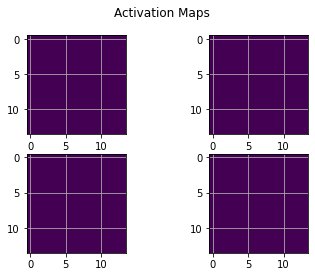

Training Loss: 3.321928094887367
Training Accuracy: 0.1
Loss while Testing: 8.304820237218419
Test Accuracy: 0.1


Epoch: 11
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


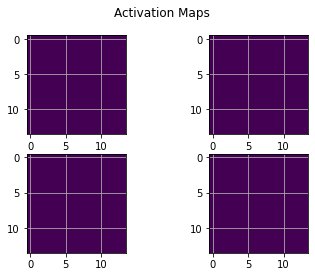

Training Loss: 3.321928094887367
Training Accuracy: 0.1
Loss while Testing: 8.304820237218419
Test Accuracy: 0.1


Epoch: 12
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


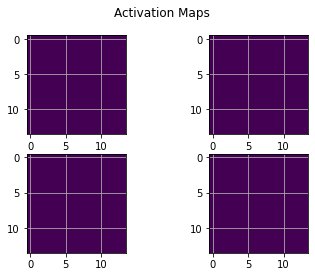

Training Loss: 3.321928094887367
Training Accuracy: 0.1
Loss while Testing: 8.304820237218419
Test Accuracy: 0.1


Epoch: 13
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


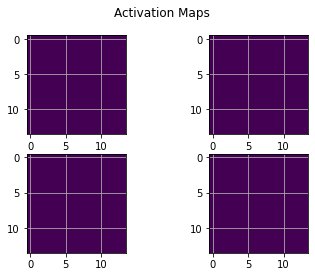

Training Loss: 3.321928094887367
Training Accuracy: 0.1
Loss while Testing: 8.304820237218419
Test Accuracy: 0.1


Epoch: 14
MiniBatch processing: 0
MiniBatch processing: 1
MiniBatch processing: 2
MiniBatch processing: 3
MiniBatch processing: 4
MiniBatch processing: 5
MiniBatch processing: 6
MiniBatch processing: 7
MiniBatch processing: 8
MiniBatch processing: 9
MiniBatch processing: 10
MiniBatch processing: 11
MiniBatch processing: 12
MiniBatch processing: 13
MiniBatch processing: 14
MiniBatch processing: 15
MiniBatch processing: 16
MiniBatch processing: 17
MiniBatch processing: 18
MiniBatch processing: 19
MiniBatch processing: 20
MiniBatch processing: 21
MiniBatch processing: 22
MiniBatch processing: 23
MiniBatch processing: 24


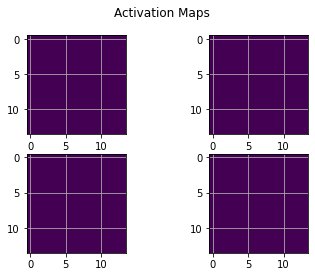

Training Loss: 3.321928094887367
Training Accuracy: 0.1
Loss while Testing: 8.304820237218419
Test Accuracy: 0.1
Execution Completed!


In [ ]:
net = Net_HW4()
trainlossSelfRms, testlossSelfRms = SelfTrainTest(net, varaintSGD = 'rms')

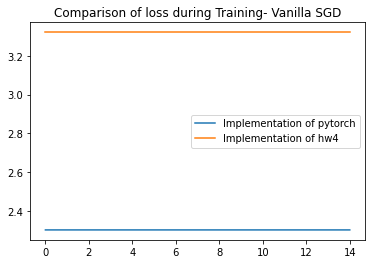

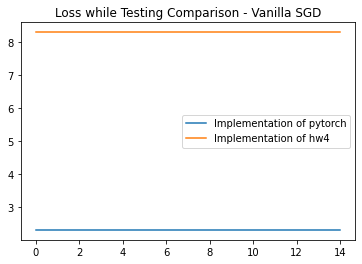

In [ ]:
plt.title('Comparison of loss during Training- Vanilla SGD')
plt.plot(range(15), SgdTrainErrors, label='Implementation of pytorch')
plt.plot(range(15), train_loss_self_sgd, label='Implementation of hw4')
plt.legend()
plt.show()

plt.title('Loss while Testing Comparison - Vanilla SGD')
plt.plot(range(15), SgdTestErrors, label='Implementation of pytorch')
plt.plot(range(15), test_loss_self_sgd, label='Implementation of hw4')
plt.legend()
plt.show()

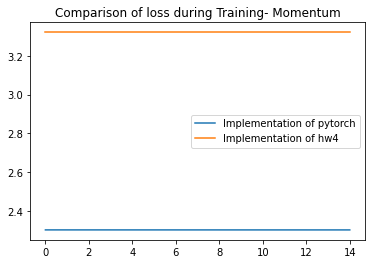

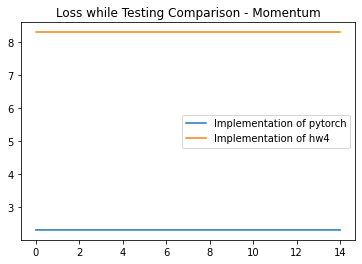

In [ ]:
plt.title('Comparison of loss during Training- Momentum')
plt.plot(range(15), MomentumTrainErrors, label='Implementation of pytorch')
plt.plot(range(15), train_loss_self_m, label='Implementation of hw4')
plt.legend()
plt.show()

plt.title('Loss while Testing Comparison - Momentum')
plt.plot(range(15), MomentumTestErrors, label='Implementation of pytorch')
plt.plot(range(15), test_loss_self_m, label='Implementation of hw4')
plt.legend()
plt.show()

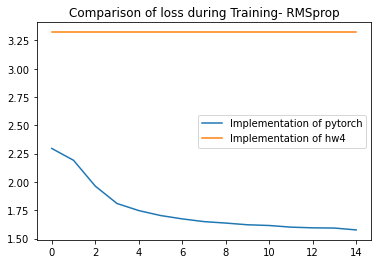

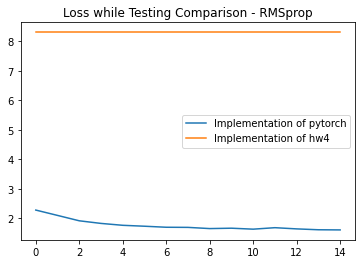

In [ ]:
plt.title('Comparison of loss during Training- RMSprop')
plt.plot(range(15), RmsTrainErrors, label='Implementation of pytorch')
plt.plot(range(15), trainlossSelfRms, label='Implementation of hw4')
plt.legend()
plt.show()

plt.title('Loss while Testing Comparison - RMSprop')
plt.plot(range(15), RmsTestErrors, label='Implementation of pytorch')
plt.plot(range(15), testlossSelfRms, label='Implementation of hw4')
plt.legend()
plt.show()